# Импорт библиотек

In [ ]:
!pip install shap
!pip install lightfm
!pip install rectools

In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import requests
import shap
import zipfile as zf
import pickle

from typing import Callable, Dict, Set, List, Optional, Any, Tuple
from scipy.sparse import csr_matrix
from lightfm import LightFM
from rectools.dataset import Dataset
from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Напишем доп функции

In [ ]:
def generate_lightfm_recs_mapper(
    model: LightFM,
    N: int,
    item_iids: List[int],  # iid - internal lfm id
    user_id_to_iid: Dict[int, int],
    item_iid_to_id: Dict[int, int],
    known_item_ids: Dict[int, Set[int]],
    user_features:  Optional[csr_matrix] = None,
    item_features: Optional[csr_matrix] = None,
    num_threads: int = 1,
) -> Callable:
    """Возвращает функцию для генерации рекомендаций в формате item_ids, scores"""
    def _recs_mapper(user):
        # Предикт для одного юзера
        user_id = user_id_to_iid[user]
        # Получаем список скоров. index - соответствует внутренним
        # индексам lightfm для айтемов т.е. ключам из item_iid_to_id
        scores_vector = model.predict(user_id, item_iids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)
        # Оставляем запас для исключения уже просмотренного из рекомендаций
        additional_N = len(known_item_ids[user_id]) if user_id in known_item_ids else 0
        total_N = N + additional_N
        # Получаем список индексов топ-N айтемов
        top_iids = np.argpartition(scores_vector, -np.arange(total_N))[-total_N:][::-1]
        # Исключаем уже просмотренное из рекомендаций
        if additional_N > 0:
            filter_items = known_item_ids[user_id]
            top_iids = [item_index for item_index in top_iids if item_iid_to_id[item_index] not in filter_items]
        # Переводим индексы lightfm айтемов в их реальные id
        final_recs = [item_iid_to_id[item_index] for item_index in top_iids]
        # Сохраняем скоры
        final_scores = scores_vector[top_iids]
        return final_recs, final_scores
    return _recs_mapper


def avg_user_metric(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        user_ids: np.ndarray,
        metric_function: Callable[[np.ndarray, np.ndarray], float],
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                group_true = y_true[l_ind: r_ind]
                if not np.all(group_true == group_true[0]):
                    avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                    n_groups += 1
                l_ind = r_ind
                cur_group_id = group_id
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

# Чтение и подготовка данных

In [ ]:
# download dataset by chunks
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)


files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [ ]:
interactions = pd.read_csv('data_original/interactions.csv', parse_dates=["last_watch_dt"])
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

### `interactions`: взаимодействия пользователь - айтем
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

In [ ]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [ ]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [ ]:
interactions.describe(datetime_is_numeric=True)

,user_id,item_id,datetime,total_dur,weight
count,5.476251e+06,5.476251e+06,5476251,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,2021-06-23 11:56:04.296268032,8.295490e+03,4.636699e+01
min,0.000000e+00,0.000000e+00,2021-03-13 00:00:00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,2021-05-25 00:00:00,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,2021-07-01 00:00:00,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,2021-07-30 00:00:00,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,2021-08-22 00:00:00,8.041167e+07,1.000000e+02
std,3.166077e+05,4.740762e+03,NaN,4.856799e+04,4.191923e+01


### `users`: данные о пользователях

- `age` бин по возрасту
- `income` бин по доходу
- `sex` пол
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [ ]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [ ]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [ ]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [ ]:
# Наиболее популярны income - income_40_60
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова
- `description` - описание

In [ ]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [ ]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating',
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [ ]:
items.describe(include='all')

,item_id,content_type,release_year,for_kids,age_rating,studios
count,15963.000000,15963.0,15963.000000,15963.0,15963.000000,15963.0
unique,NaN,2.0,NaN,3.0,NaN,39.0
top,NaN,0.0,NaN,-1.0,NaN,-1.0
freq,NaN,12002.0,NaN,15397.0,NaN,14898.0
mean,8268.453424,NaN,2007.969492,NaN,12.945937,NaN
std,4773.841513,NaN,16.835890,NaN,5.495760,NaN
min,0.000000,NaN,1897.000000,NaN,0.000000,NaN
25%,4141.500000,NaN,2007.000000,NaN,12.000000,NaN
50%,8266.000000,NaN,2014.000000,NaN,16.000000,NaN
75%,12414.500000,NaN,2018.000000,NaN,16.000000,NaN


# Трейн-вал-тест сплит

In [ ]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


## Схема валидации с разбиением по юзерам

In [ ]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [ ]:
# Для базовых моделей первого уровня (в нашем случае только lightfm)
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

# Обучаем модель первого уровня

In [ ]:
candidates_lightfm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/lightfm_recos.csv')
candidates_lightfm

,user_id,item_id,score_lightfm,rank_lightfm
0,176549,15297,1.119614e-05,1
1,176549,10440,9.081667e-06,2
2,176549,13865,8.349782e-06,3
3,176549,4151,7.709520e-06,4
4,176549,3734,6.609078e-06,5
...,...,...,...,...
36043745,805174,10732,8.555674e-07,46
36043746,805174,12192,8.396653e-07,47
36043747,805174,598,8.359532e-07,48
36043748,805174,16509,8.094983e-07,49


In [ ]:
candidates_pop = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/popular_recos.csv')
candidates_pop

,item_id,score_pop,rank_pop
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5
...,...,...,...
14936,15235,1.0,14937
14937,87,1.0,14938
14938,7457,1.0,14939
14939,6270,1.0,14940


In [ ]:
candidates = candidates_lightfm.merge(candidates_pop, how='left',on=[Columns.Item])

In [ ]:
candidates

,user_id,item_id,score_lightfm,rank_lightfm,score_pop,rank_pop
0,176549,15297,1.119614e-05,1,137128.0,2.0
1,176549,10440,9.081667e-06,2,141889.0,1.0
2,176549,13865,8.349782e-06,3,93403.0,3.0
3,176549,4151,7.709520e-06,4,69641.0,4.0
4,176549,3734,6.609078e-06,5,50004.0,6.0
...,...,...,...,...,...,...
36043745,805174,10732,8.555674e-07,46,2870.0,158.0
36043746,805174,12192,8.396653e-07,47,14317.0,23.0
36043747,805174,598,8.359532e-07,48,3198.0,130.0
36043748,805174,16509,8.094983e-07,49,6123.0,55.0


In [ ]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ),
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'rank_lightfm')
models_metrics['pop'] = calc_metrics_(candidates, 'rank_pop')
models_metrics

{'lfm': {'Precision@10': 0.02527742390987368,
  'recall@10': 0.08375670059036246,
  'ndcg@10': 0.031892878150265314,
  'map@10': 0.04272965610294717,
  'novelty@10': 3.085834788357883},
 'pop': {'Precision@10': 0.01955397295596519,
  'recall@10': 0.06567592267978621,
  'ndcg@10': 0.02416983974819715,
  'map@10': 0.03136498967480883,
  'novelty@10': 3.1365885705885543}}

## Формируем датасет для ранкера

In [ ]:
# Получаем длину истории юзера
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [ ]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users,
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [ ]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

## Джойним кандидатов и юзер/айтем фичи

In [ ]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)],
        candidates_df[candidates_df['user_id'].isin(user_list)],
        how='right',
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score_lightfm: float =  df['score_lightfm'].min() - 0.01
    max_rank_lightfm: int = df['rank_lightfm'].max() + 1  # 101
    min_score_pop: float =  df['score_pop'].min() - 0.01
    max_rank_pop: int = df['rank_pop'].max() + 1  # 101

    default_values = {
        'score_lightfm': min_score_lightfm, 'rank_lightfm': max_rank_lightfm,
        'score_pop': min_score_pop, 'rank_pop': max_rank_pop,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,score_lightfm,rank_lightfm,score_pop,rank_pop
5866506,3,142,2021-08-13,5892.0,100.0,0.000007,7,35862.0,8.0
5866545,3,598,2021-07-01,0.0,0.0,0.000004,46,3198.0,130.0
5866539,3,849,2021-07-01,0.0,0.0,0.000004,40,13304.0,26.0


In [ ]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df,
        users,
        how='left',
        on=['user_id']
    )
    df = pd.merge(
        df,
        items,
        how='left',
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,score_lightfm,rank_lightfm,score_pop,rank_pop,age,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,142,2021-08-13,5892.0,100.0,0.000007,7,35862.0,8.0,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
1,3,598,2021-07-01,0.0,0.0,0.000004,46,3198.0,130.0,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,6.0,-1,3198.0,16.908380
2,3,849,2021-07-01,0.0,0.0,0.000004,40,13304.0,26.0,-1,...,0.0,11957.864865,2858.0,0,2018.0,-1,18.0,-1,13304.0,16.444678


In [ ]:
for name in ['train', 'val', 'test']:
    path: str = f'/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/ranker_{name}.csv'
    # eval(f'ranker_{name}').to_csv(path, index=False)
    locals()[f'ranker_{name}'].to_csv(path, index=False)

# Pointwise

In [ ]:
# таргет бинарный, так что -
# будем считать просмотр хорошим если доля досмотра больше половины

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,score_lightfm,rank_lightfm,score_pop,rank_pop,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,142,2021-08-13,5892.0,100.0,0.000007,7,35862.0,8.0,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,1
1,3,598,2021-07-01,0.0,0.0,0.000004,46,3198.0,130.0,-1,...,11957.864865,2858.0,0,2020.0,-1,6.0,-1,3198.0,16.908380,0
2,3,849,2021-07-01,0.0,0.0,0.000004,40,13304.0,26.0,-1,...,11957.864865,2858.0,0,2018.0,-1,18.0,-1,13304.0,16.444678,0


In [ ]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем


def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=["user_id", "item_id"],
        inplace=True,
    )
    groups_df = (
        df[["user_id", "item_id"]]
        .groupby(by=["user_id"])
        .count()
        .rename(columns={"item_id": "group_size"})
    )
    df = pd.merge(df, groups_df, how="left", on=["user_id"])
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df["group_size"] >= 50]

    # Колонка больше не нужна
    df.drop(columns=["group_size"], inplace=True)
    return df

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)

# ranker_test = filter_group(ranker_test)

In [ ]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight',
       'score_lightfm', 'rank_lightfm', 'score_pop', 'rank_pop', 'age',
       'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop',
       'user_last_pop', 'content_type', 'release_year', 'for_kids',
       'age_rating', 'studios', 'item_pop', 'item_avg_hist', 'target'],
      dtype='object')

In [ ]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'score_lightfm', 'rank_lightfm', 'score_pop', 'rank_pop',
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из нranker_trainих категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [ ]:
early_stopping_rounds = 32

params = {
    'objective': 'binary',
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Info] Number of positive: 53540, number of negative: 6706710
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.863645
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.175463
[LightGBM] [Debug] init for col-wise cost 0.174529 seconds, init for row-wise cost 0.882996 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.437466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 6760250, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007920 -> initscore=-4.830435
[LightGBM] [Info] Start trainin

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [ ]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_['valid_0']['binary_logloss']

0.03813444018663262

In [ ]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

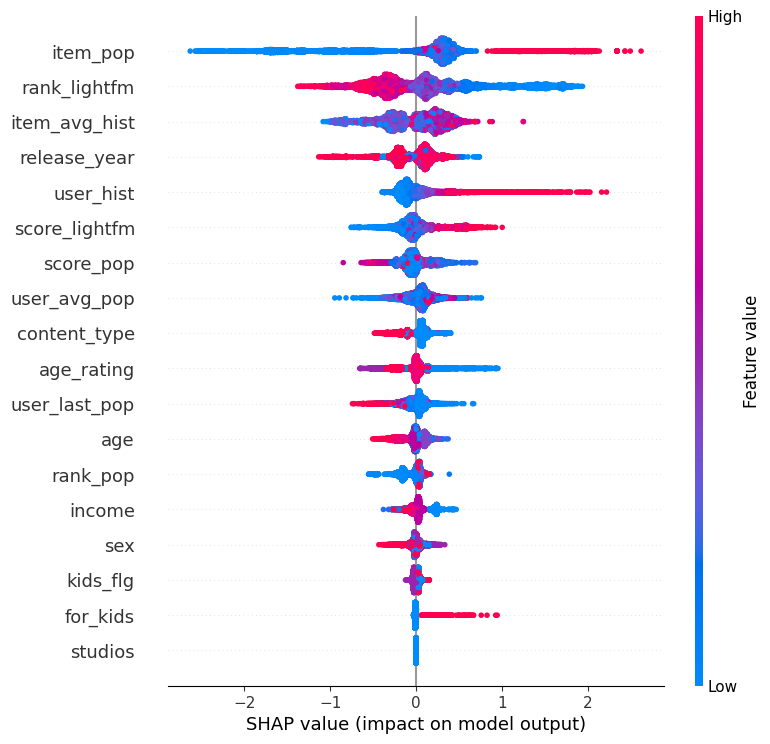

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

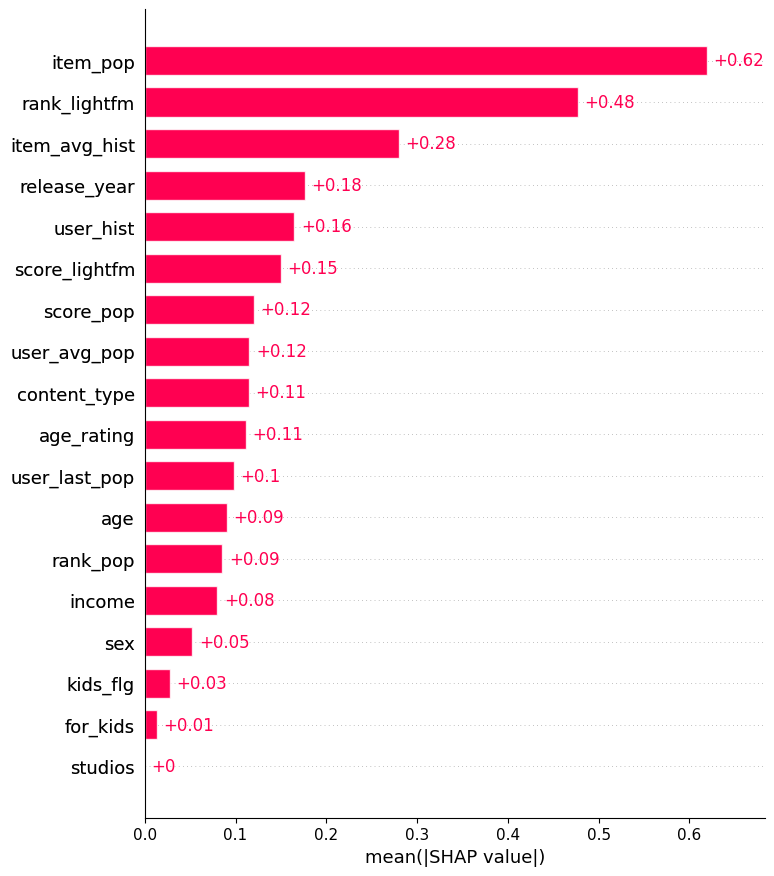

In [ ]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [ ]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.00084186, 0.01742886, 0.0001747 , ..., 0.08028838, 0.0066571 ,
       0.00123344])

In [ ]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df['rank_lightfm'] < 21).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [ ]:
ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')

In [ ]:
# Считаем рок аук от sklearn (не усредненный по юзерам)
roc_auc_score(y_true, y_pred)  # Получилась ерунда

0.8619015139880871

In [ ]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    )
)
# Ранкер вроде ранжирует, но вот весь пайплайн в целом - не очень

(0.8722739524067252, 0.8116678551175891)

In [ ]:
# Получим значения метрик, а так же
# вспомним, какие метрики были у LightFM и сравним их между собой. Что не так?
models_metrics['pointwise'] = calc_metrics_(ranker_test, 'pointwise_rank')
models_metrics['pointwise_hybrid'] = calc_metrics_(ranker_test, 'pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm','pop', 'pointwise', 'pointwise_hybrid']]

,lfm,pop,pointwise,pointwise_hybrid
Precision@10,0.025277,0.019554,0.026515,0.023089
recall@10,0.083757,0.065676,0.087656,0.077964
ndcg@10,0.031893,0.024170,0.034594,0.032125
map@10,0.042730,0.031365,0.046976,0.045318
novelty@10,3.085835,3.136589,3.556270,2.919524


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/pointwise.pkl"
pickle.dump(pointwise_model, open(MODEL_PATH, "wb"))

# Pairwise/Listwise

In [ ]:
# Для обучения ранжированию нужно правильно сформировать группы.
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества
# ранжируемых айтемов на каждого юзера (группу).

# Официальная [дока|https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker]:
# sum(group) = n_samples.
# For example, if you have a 100-document dataset with
# group = [10, 20, 40, 10, 10, 10], that means that you have 6 groups,
# where the first 10 records are in the first group

# Важно! Если вы решите использовать CatBoostRanker или XGBoostRanker - там группы строятся по-другому.

def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [ ]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,score_lightfm,rank_lightfm,score_pop,rank_pop,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker
0,3,142,2021-08-13,5892.0,100.0,0.000007,7,35862.0,8.0,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,2
1,3,598,2021-07-01,0.0,0.0,0.000004,46,3198.0,130.0,-1,...,11957.864865,2858.0,0,2020.0,-1,6.0,-1,3198.0,16.908380,0
2,3,849,2021-07-01,0.0,0.0,0.000004,40,13304.0,26.0,-1,...,11957.864865,2858.0,0,2018.0,-1,18.0,-1,13304.0,16.444678,0


In [ ]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.863645
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.173899
[LightGBM] [Debug] init for col-wise cost 0.171192 seconds, init for row-wise cost 0.892173 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [ ]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.7498291170447633),
             ('ndcg@5', 0.7742717698047263),
             ('ndcg@10', 0.7953860153940757)])

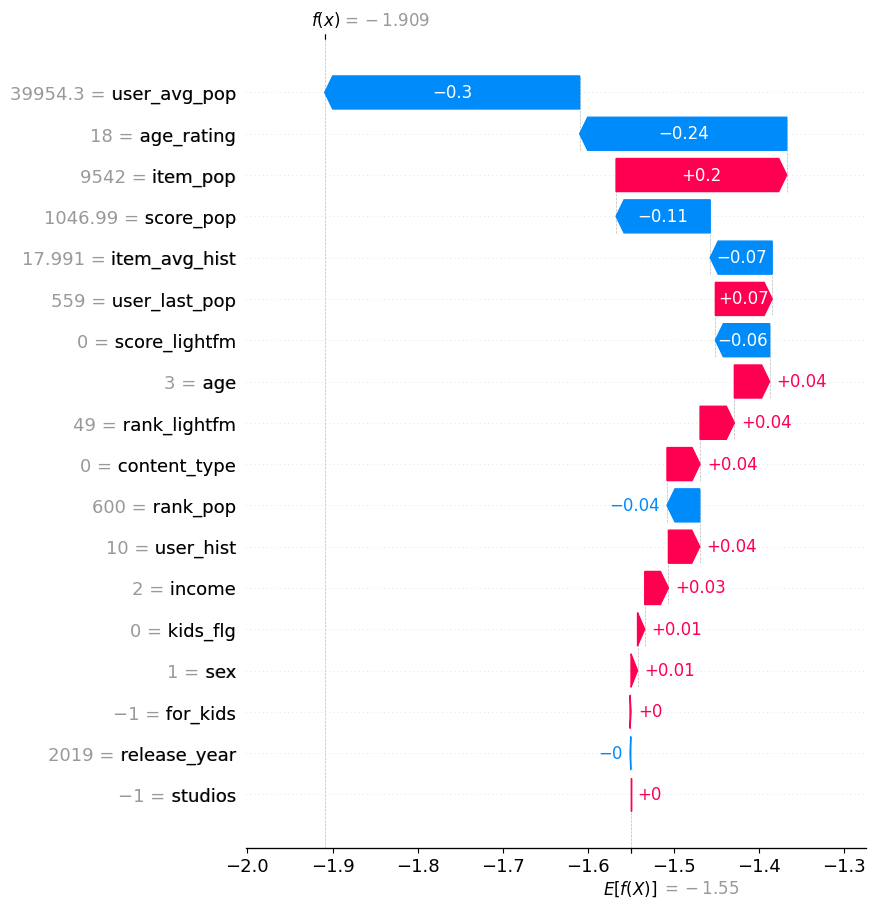

In [ ]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

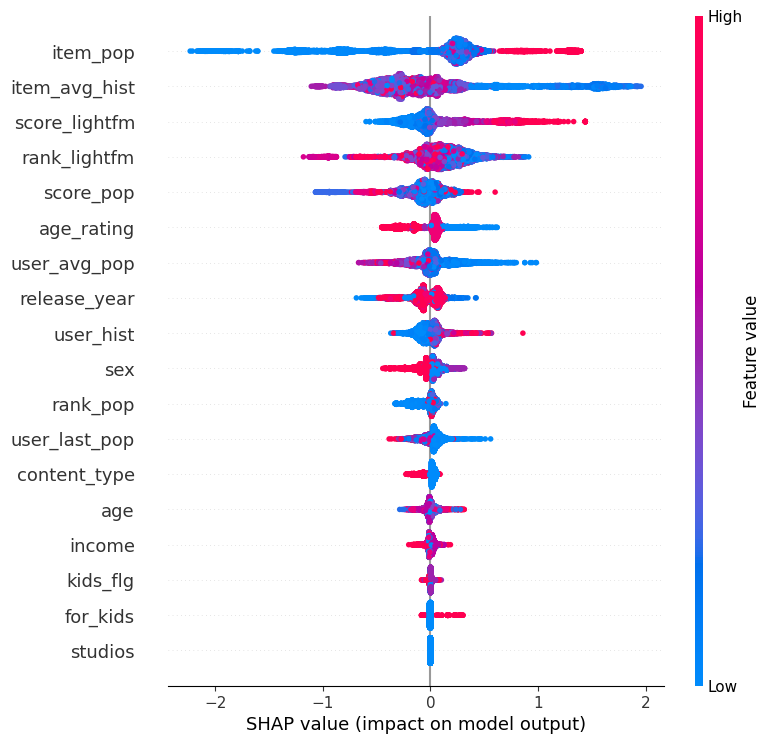

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

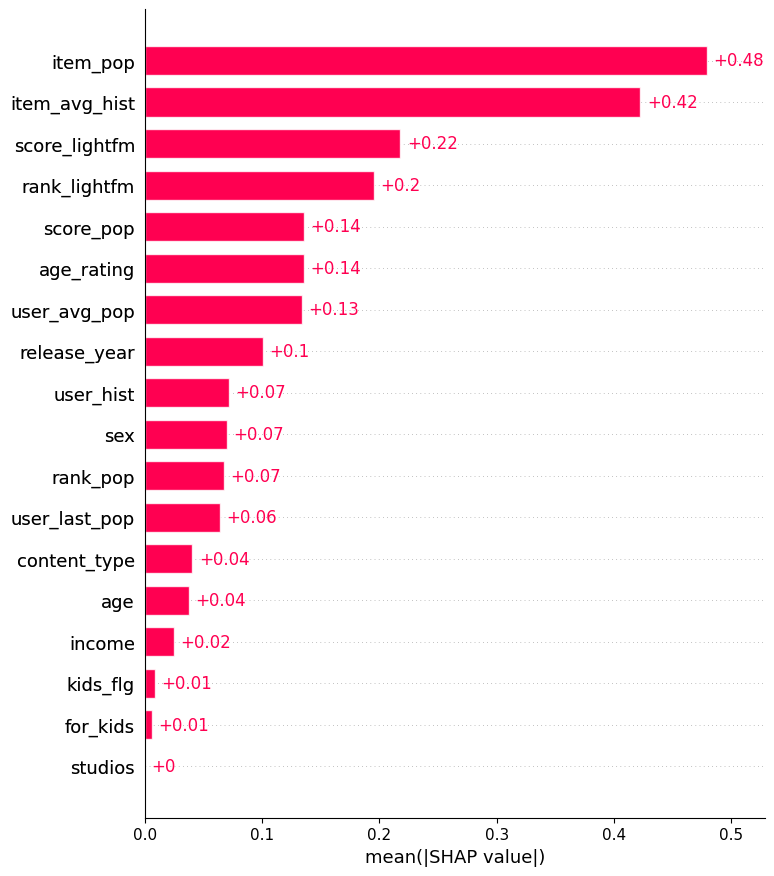

In [ ]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [ ]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,score_lightfm,rank_lightfm,score_pop,rank_pop,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
30,53,9728,2021-07-01,0.0,0.0,6.972841e-06,2,1046.99,600.0,3,...,-1,18.0,-1,76978.0,11.165736,0,1.093345,1,1.093345,1
37,53,12192,2021-07-01,0.0,0.0,8.377504e-07,43,14317.00,23.0,3,...,-1,16.0,-1,14317.0,13.140881,0,0.749210,2,-6.213434,101
11,53,3734,2021-07-30,11529.0,100.0,6.522996e-06,3,50004.00,6.0,3,...,-1,16.0,-1,50004.0,12.134949,2,0.536554,3,0.536554,3


In [ ]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

In [ ]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/listwise.pkl"
pickle.dump(listwise_model, open(MODEL_PATH, "wb"))

# Итоговые метрики

In [ ]:
pd.DataFrame(models_metrics)[['lfm','pop','pointwise', 'pointwise_hybrid','listwise', 'listwise_hybrid']]

,lfm,pop,pointwise,pointwise_hybrid,listwise,listwise_hybrid
Precision@10,0.025277,0.019554,0.026515,0.023089,0.028358,0.022843
recall@10,0.083757,0.065676,0.087656,0.077964,0.095721,0.077299
ndcg@10,0.031893,0.024170,0.034594,0.032125,0.036874,0.031601
map@10,0.042730,0.031365,0.046976,0.045318,0.051147,0.044617
novelty@10,3.085835,3.136589,3.556270,2.919524,3.639984,2.906639


# Интеграция в сервис

In [ ]:
for name in ["train", "val", "test"]:
    path: str = f"/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/ranker_{name}.csv"
    locals()[f"ranker_{name}"] = pd.read_csv(path)

In [ ]:
listwise_model = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/listwise.pkl", "rb"))

In [ ]:
ranker = pd.concat([ranker_train,ranker_val,ranker_test])

In [ ]:
ranker

,user_id,item_id,datetime,total_dur,weight,score_lightfm,rank_lightfm,score_pop,rank_pop,age,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,142,2021-08-13,5892.0,100.0,7.410495e-06,7,35862.00,8.0,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
1,3,598,2021-07-01,0.0,0.0,3.566902e-06,46,3198.00,130.0,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,6.0,-1,3198.0,16.908380
2,3,849,2021-07-01,0.0,0.0,3.658194e-06,40,13304.00,26.0,-1,...,0.0,11957.864865,2858.0,0,2018.0,-1,18.0,-1,13304.0,16.444678
3,3,1465,2021-07-01,0.0,0.0,3.621730e-06,42,4429.00,79.0,-1,...,0.0,11957.864865,2858.0,1,2021.0,-1,18.0,-1,4429.0,13.185595
4,3,1819,2021-07-01,0.0,0.0,3.830904e-06,35,9792.00,30.0,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,9792.0,14.719669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441795,1097506,14684,2021-07-01,0.0,0.0,1.042806e-06,31,1046.99,600.0,2,...,10.0,7449.200000,7322.0,0,2013.0,-1,18.0,-1,3259.0,25.654802
1441796,1097506,14741,2021-07-01,0.0,0.0,2.042123e-06,18,19639.00,16.0,2,...,10.0,7449.200000,7322.0,0,2020.0,-1,16.0,-1,19639.0,15.725292
1441797,1097506,15297,2021-07-01,0.0,0.0,1.094224e-05,1,137128.00,2.0,2,...,10.0,7449.200000,7322.0,1,2021.0,-1,18.0,-1,137128.0,7.364295
1441798,1097506,16166,2021-07-01,0.0,0.0,1.648185e-06,21,1046.99,600.0,2,...,10.0,7449.200000,7322.0,0,2016.0,-1,6.0,-1,8522.0,20.144802


In [ ]:
y_pred: np.ndarray = listwise_model.predict(ranker[cols])

In [ ]:
ranker = add_score_and_rank(ranker, y_pred, 'listwise')
ranker.head(3)

,user_id,item_id,datetime,total_dur,weight,score_lightfm,rank_lightfm,score_pop,rank_pop,age,...,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
46,3,15297,2021-07-01,0.0,0.0,0.000014,1,137128.00,2.0,-1,...,2021.0,-1,18.0,-1,137128.0,7.364295,2.732438,1,2.732438,1
27,3,9728,2021-07-23,10448.0,100.0,0.000010,5,709.99,892.0,-1,...,2021.0,-1,18.0,-1,76978.0,11.165736,1.517408,2,1.517408,2
30,3,10440,2021-07-23,44827.0,90.0,0.000012,2,141889.00,1.0,-1,...,2021.0,-1,18.0,-1,141889.0,8.068716,1.516995,3,1.516995,3


In [ ]:
ranker_recos = ranker[['user_id','item_id', 'listwise_rank']]
ranker_recos = (ranker.sort_values(['user_id', 'listwise_rank']).groupby('user_id').head(10)).drop('listwise_rank', axis=1, inplace=True)
ranker_recos.head()

,user_id,item_id
46,3,15297
27,3,9728
30,3,10440
39,3,13865
48,3,16228


In [ ]:
ranker_recos.to_csv('/content/drive/MyDrive/Colab Notebooks/ИТМО/Recsys/6/ranker_recos.csv')

# Что сделано

Обучено две модели ранкера

Выбрана лучшая модель

На первом уровне использована модель, которая может обрабатывать холодных пользователей

Всего на первом уровне не менее двух моделей